## Required Packages 

In [1]:
import tensorflow as tf
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_error
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam,Nadam,RMSprop,Adamax
from tensorflow.keras.layers import Masking
from sklearn.preprocessing import MinMaxScaler
#from tbats import TBATS
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.multioutput import MultiOutputRegressor
import json
import sktime
from sktime.forecasting.tbats import TBATS


## Read the data 

In [2]:
# Read the data
data=pd.read_csv('timeseries.csv')
data['ts']=pd.to_datetime(data['ts'])
data.head(5)

,ts,visitors
0,2015-01-02 10:45:00,1.0
1,2015-01-02 11:00:00,14.0
2,2015-01-02 11:15:00,13.0
3,2015-01-02 11:30:00,1.0
4,2015-01-02 11:45:00,6.0


In [3]:
forecast_data=pd.DataFrame(data.resample('H', on='ts').visitors.sum())
forecast_data.reset_index(inplace=True)
forecast_data.tail(24)

,ts,visitors
42300,2019-10-30 22:00:00,0.0
42301,2019-10-30 23:00:00,0.0
42302,2019-10-31 00:00:00,0.0
42303,2019-10-31 01:00:00,0.0
42304,2019-10-31 02:00:00,0.0
42305,2019-10-31 03:00:00,0.0
42306,2019-10-31 04:00:00,0.0
42307,2019-10-31 05:00:00,0.0
42308,2019-10-31 06:00:00,0.0
42309,2019-10-31 07:00:00,0.0


In [4]:
def closed(visitors):
    ret=None
    
    if visitors==0:
        ret=1
    else:
        ret=0
    return ret

In [5]:
forecast_data['Month']=forecast_data['ts'].apply(lambda x: x.month)
forecast_data['Day']=forecast_data['ts'].apply(lambda x: x.weekday())
forecast_data['Hour']=forecast_data['ts'].apply(lambda x: x.hour)
forecast_data['Closed']=forecast_data['visitors'].apply(lambda x: closed(x))
forecast_data.tail(10)

,ts,visitors,Month,Day,Hour,Closed
42314,2019-10-31 12:00:00,143.0,10,3,12,0
42315,2019-10-31 13:00:00,151.0,10,3,13,0
42316,2019-10-31 14:00:00,112.0,10,3,14,0
42317,2019-10-31 15:00:00,78.0,10,3,15,0
42318,2019-10-31 16:00:00,52.0,10,3,16,0
42319,2019-10-31 17:00:00,80.0,10,3,17,0
42320,2019-10-31 18:00:00,112.0,10,3,18,0
42321,2019-10-31 19:00:00,147.0,10,3,19,0
42322,2019-10-31 20:00:00,147.0,10,3,20,0
42323,2019-10-31 21:00:00,59.0,10,3,21,0


## Data visualization

<AxesSubplot:xlabel='Day', ylabel='visitors'>

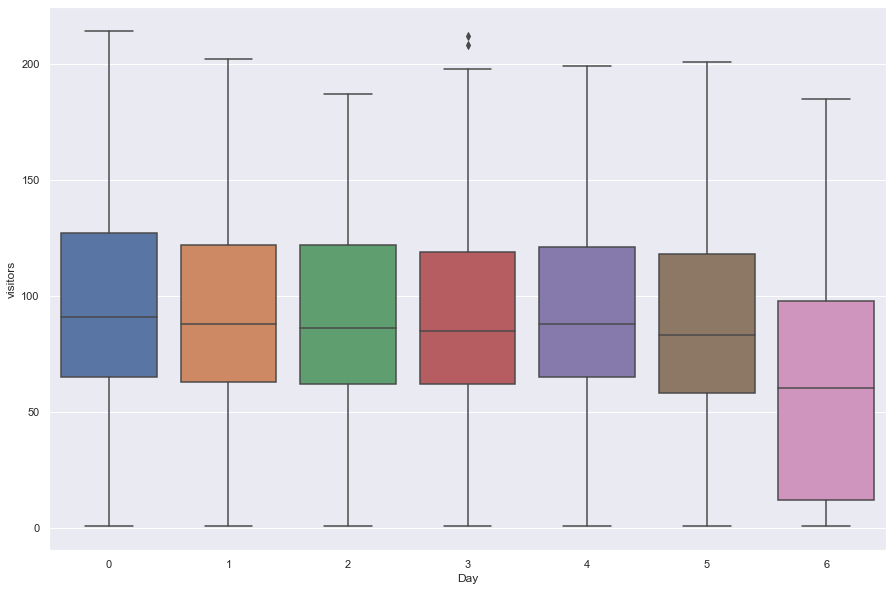

In [6]:
sns.set(rc={'figure.figsize':(15,10)})
sns.boxplot(x="Day", y="visitors", data=forecast_data.loc[forecast_data['Closed']==0])

<AxesSubplot:xlabel='Month', ylabel='visitors'>

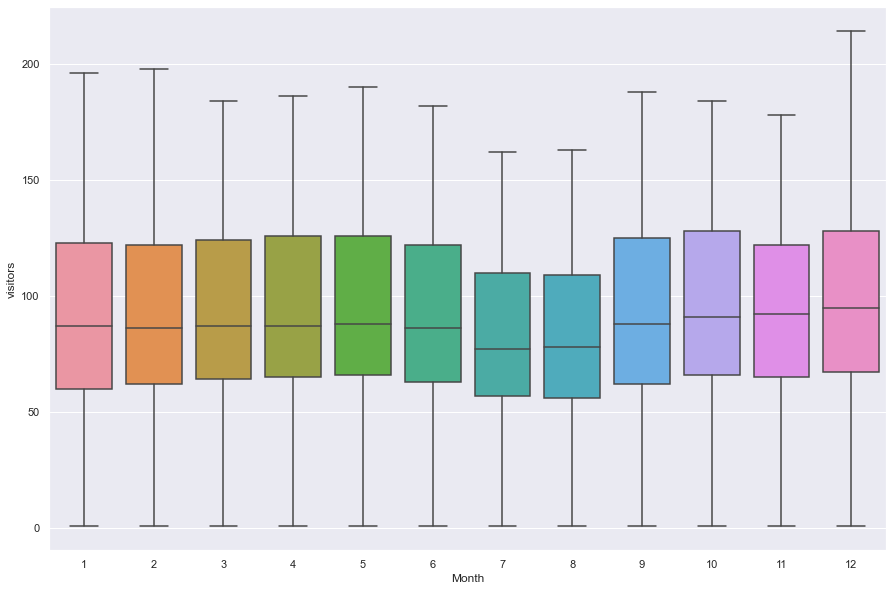

In [7]:
sns.boxplot(x="Month", y="visitors", data=forecast_data.loc[forecast_data['Closed']==0])

## Data cleaning 

In [8]:
def streming_outlier_detection(ts,k,s,alpha):
    
    #streaming z-score outlier detection
    
    #input
    # ts - time series values
    # k - last k seasonal elements for comparison
    # s - seasonality period
    # alpha - standard deviation multiplication factor 
    
    #output
    #outliers list: index and values
    # ts_copy: new timeseries with imputation on the outliers
    
    ts_copy=np.copy(ts)
    outliers=[]
    
    prev_elements=np.ones(k)
    
    for i in range(k*s,len(ts)):
        
        for j in range(k):
            prev_elements[j]=ts[i-(j+1)*s]
            
        mu=np.mean(prev_elements)
        sigma=np.std(prev_elements)
        
        upper_whisker=mu+alpha*sigma
        lower_whisker=mu-alpha*sigma
        
        if ts[i]>upper_whisker or ts[i]<lower_whisker:
            outliers.append([i,ts[i]])
            masked=np.ma.masked_equal(prev_elements, 0)
            ts_copy[i]=np.where(masked.mean()==None, 0, masked.mean())
            
    return outliers,ts_copy

In [9]:
outliers,new_ts=streming_outlier_detection(forecast_data['visitors'].values,k=53,s=168,alpha=2)

In [10]:
forecast_data['filtered_visitors']=new_ts
forecast_data

,ts,visitors,Month,Day,Hour,Closed,filtered_visitors
0,2015-01-02 10:00:00,82.0,1,4,10,0,82.0
1,2015-01-02 11:00:00,100.0,1,4,11,0,100.0
2,2015-01-02 12:00:00,127.0,1,4,12,0,127.0
3,2015-01-02 13:00:00,162.0,1,4,13,0,162.0
4,2015-01-02 14:00:00,123.0,1,4,14,0,123.0
...,...,...,...,...,...,...,...
42319,2019-10-31 17:00:00,80.0,10,3,17,0,80.0
42320,2019-10-31 18:00:00,112.0,10,3,18,0,112.0
42321,2019-10-31 19:00:00,147.0,10,3,19,0,147.0
42322,2019-10-31 20:00:00,147.0,10,3,20,0,147.0


In [11]:
def seasonal_naive(y_train,horizon,s):
    # input
    
    # y_train - input time series
    # forecast - horizon
    # s - seasonal period
    
    #output
    # y_pred - forecast values
    
    y_pred=np.zeros(horizon)
    N=len(y_train)
    
    for i in range(horizon):
        if i<s:
            y_pred[i]=y_train[N-s+i]
        else:
            y_pred[i]=y_pred[i-s]
    
    return y_pred

In [12]:
def seasonal_MASE(y_true,y_pred,y_train,s):
    
    
    y_pred_naive=seasonal_naive(y_train,len(y_pred),s)
    
    return mean_absolute_error(y_true,y_pred)/mean_absolute_error(y_true,y_pred_naive)
    

In [13]:
def model_metrics(y_true,y_pred):
    d_metrics={}
    d_metrics['rmse']=np.sqrt(mean_squared_error(y_true,y_pred))
    d_metrics['mae']=mean_absolute_error(y_true,y_pred)
    d_metrics['r2_score']=r2_score(y_true,y_pred)
    
    return d_metrics
    

## Time Series Forecasting 

In [14]:
nprev=720

## TBATS

In [ ]:
# We will only use past 3 months do train our SARIMA model(2160 hours)
import time
start=time.time()
df=forecast_data[['filtered_visitors']]
train=df[:-nprev]
test=df[-nprev:]

# Create estimator
estimator = TBATS(sp=[168,672,8736],n_jobs=-1)

# Fit model
estimator.fit(y=train)

# Forecast 720 steps ahead
forecast = estimator.predict(fh=nprev)
forecast=np.round(forecast)


end=time.time()
print(round(end-start,2))

## HistGradientBoosting

In [49]:
ind=test!=0

In [15]:
model_metrics(forecast[ind],test[ind])

NameError: name 'forecast' is not defined

In [15]:
hgbr=HistGradientBoostingRegressor()

In [16]:
X=forecast_data[['Month','Day','Hour']]
X_train=X[:-nprev]
X_test=X[-nprev:]
y_train=forecast_data[:-nprev]['filtered_visitors']
y_test=forecast_data[-nprev:]['visitors']

In [17]:
hgbr.fit(X_train,y_train)

HistGradientBoostingRegressor()

In [18]:
forecast=hgbr.predict(X_test)

In [19]:
model_metrics(y_test,forecast)

{'rmse': 11.013653087965613,
 'mae': 4.972327890238125,
 'r2_score': 0.9580061134895852}

In [20]:
seasonal_MASE(y_test,forecast,y_train,s=168)

0.7705716919869673

In [23]:
def to_supervised(timeseries,n_lags,n_output=1):
    
    N=len(timeseries)
    X=np.zeros((N-n_lags-n_output+1,n_lags))
    y=np.zeros((X.shape[0],n_output))
    
    for i in range(N-n_lags):
        aux=np.zeros(n_lags)
        for j in range(i,i+n_lags,1):
            aux[j-i]=timeseries[j]
        if i+n_lags+n_output<=N:
            X[i,:]=aux
            y[i,:]=timeseries[i+n_lags:i+n_lags+n_output]

    return X,y



X,y=to_supervised(forecast_data['filtered_visitors'].values,n_lags=nprev,n_output=nprev)

In [24]:
X_train=X[:-1]
y_train=y[:-1]
X_test=X[-1:]
y_test=y[-1:]

In [62]:
y_train[-1,:].reshape(1,-1)

array([[ 47.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
         65.        ,  76.        , 120.        , 130.        ,
        151.        , 125.        ,  82.        ,  58.        ,
         62.        ,  77.        , 117.        , 142.        ,
         40.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
         69.        ,  72.        , 102.        , 139.        ,
        149.        , 137.        ,  69.        ,  48.        ,
         64.        ,  82.        , 111.        , 148.        ,
         57.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
         73.        ,  78.        , 109.

In [ ]:
from kerasbeats import NBeatsModel
model = NBeatsModel(lookback=720,horizon=720, batch_size)
model.build_layer()
model.fit(X_train,y_train)

In [48]:
X_test=X_test.reshape(X_test.shape[0],X_test.shape[1],1)

In [49]:
forecast=model.predict(X_test)

In [52]:
y_train.shape

(40884, 720)

In [28]:
X_test.shape

(1, 720, 1)

In [25]:
X_test=X_test.reshape(X_test.shape[0],X_test.shape[1],1)
model.predict(X_test)

array([[nan]], dtype=float32)

In [28]:
np.sum(np.isnan(y_train))

0

In [25]:
mms_X=MinMaxScaler()
mms_y=MinMaxScaler()
X_train=mms_X.fit_transform(X_train)
y_train=mms_y.fit_transform(y_train)

In [29]:
y_t=y_train[-1,:].reshape(1,-1)

In [33]:
y_t.shape

(1, 720)

In [36]:
mms_y.inverse_transform(y_t).flatten().shape

(720,)

In [26]:
X_train=X_train.reshape(X_train.shape[0],X_train.shape[1],1)
model = Sequential()
model.add(Masking(mask_value=0,input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(100, activation='relu', dropout=0.05,return_sequences=True, input_shape=(X_train.shape[1],X_train.shape[2])))
model.add(LSTM(100, activation='relu',dropout=0.05))
model.add(Dense(nprev))
opt=Adam(learning_rate=0.0001,clipnorm=1,clipvalue=1)
#Adam,Nadam,RMSprop,Adamax
model.compile(optimizer=opt, loss='mse')
model.fit(X_train,y_train,epochs=5,batch_size=500)

Epoch 1/5
 4/82 [>.............................] - ETA: 16:04 - loss: 0.1002

KeyboardInterrupt: 

In [ ]:
X_test=mms_X.transform(X_test)
X_test=X_test.reshape(X_test.shape[0],X_test.shape[1],1)
forecast=model.predict(X_test)
forecast=mms_y.inverse_transform(forecast).flatten()

In [54]:
len(y_train)

32700

In [ ]:
y_test=y_test.flatten()
ind=y_test!=0

In [ ]:
model_metrics(y_test[ind],forecast[ind])

In [34]:
mms_X=MinMaxScaler()
mms_y=MinMaxScaler()
X_train=mms_X.fit_transform(X_train)
y_train=mms_y.fit_transform(y_train)

In [35]:
mlp=MLPRegressor(hidden_layer_sizes=(10000,100),max_iter=100,verbose=True)
#mo=MultiOutputRegressor(HistGradientBoostingRegressor())
mlp.fit(X_train, y_train)

Iteration 1, loss = 0.05551226
Iteration 2, loss = 0.03917938
Iteration 3, loss = 0.03651113


C:\Users\quilo\.conda\envs\DataScience\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:699: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


MLPRegressor(hidden_layer_sizes=(10000, 100), max_iter=100, verbose=True)

In [38]:
X_test=mms_X.transform(X_test)

In [39]:
forecast=mlp.predict(X_test)
forecast=mms_y.inverse_transform(forecast).flatten()
forecast[forecast<0]=0
y_test=y_test.flatten()
ind=y_test!=0
model_metrics(y_test[ind],forecast[ind])


{'rmse': 65.32019295947079,
 'mae': 55.2540446130351,
 'r2_score': -2.381444702394546}

In [ ]:
0.8882

In [ ]:
0.8917670493845974

In [ ]:
model_metrics(y_test.flatten()[index_aberto],forecast[index_aberto])

In [ ]:
index_aberto=np.where(y_test != 0)[0]

In [38]:
lags=8904
X,y=to_supervised(forecast_data['filtered_visitors'].values,n_lags=lags)
df=pd.DataFrame(np.hstack((X,y)),columns=['lag'+str(i-1) for i in range(lags+1,0,-1)])
df=df.rename(columns={'lag0':'target'})

In [39]:
df.columns[a]

NameError: name 'a' is not defined

In [40]:
best_features=[i for i in range(0,lags,168)]

In [41]:
X=df.iloc[:,:-1].values
y=df.iloc[:,-1].values
X_train=X[:-nprev,:]
y_train=y[:-nprev]
X_test=X[-nprev:]
y_test=y[-nprev:]

In [55]:
X_train[0,best_features]

array([ 82.,  86.,  76.,  89.,  70.,  72.,  92.,  66.,  81.,  96., 102.,
        83.,  90.,   0.,  89.,  83., 100.,   0.,  89., 102.,  84.,  82.,
       102.,  94.,  80.,  62.,  71.,  78.,  72.,  79.,  77.,  74.,  72.,
        79.,  83.,  77.,  84.,  96.,  96.,  85.,  73.,  78.,  79.,  88.,
        80.,  82.,  78.,  97.,  85.,  90., 104.,   0.,   0.])

In [56]:
train_predict(model,X_train,y_train,X_test,y_test,steps,best_features)

0.0

In [42]:
hgbr=HistGradientBoostingRegressor()

def train_predict(model,X_train,y_train,X_test,y_test,steps,best_features):
    model.fit(X_train[:,best_features],y_train)
    forecast=[]
    for k in range(len(y_test)):
        X_input=[]
        for i in range(steps):
            if(k+i<steps):
                X_input.append(X_train[-1][k+i])
            else:
                X_input.append(forecast[-(steps-k-i)])
        X_input=np.array(X_input)[best_features]
        forecast.append(round(max(model.predict(np.array(X_input).reshape((1,len(X_input))))[0],0)))
    return forecast
forecast=train_predict(hgbr,X_train,y_train,X_test,y_test,steps=lags,best_features=best_features)

In [43]:
model_metrics(y_test,forecast)

{'rmse': 28.123443305944363,
 'mae': 16.28917588402883,
 'r2_score': 0.7250297745165959}

In [38]:
def connect_sqlserver(server='deti-sql-aulas.ua.pt',database='sisqualFORECASTDATA',username='sisqual',password='rh4.0'):
    con = pyodbc.connect('DRIVER={SQL Server Native Client 11.0};SERVER='+server+';DATABASE='+database+';UID='+username+';PWD='+ password)
    cursor = con.cursor()

    return con,cursor


In [39]:
con,cursor=connect_sqlserver()

NameError: name 'pyodbc' is not defined